# Implémentation d'un modèle de scoring chez Prêt à dépeser (2/2 modélisation)

Dans cette partie, nous allons effectuer les differents tests d'algorithmes et nous allons voir comment optimiser le modèle choisi de point de vue métier. Enfin nous allons voir comment interpréter les résultats obtenus. 

## Sommaire 
[1. La préparation des données et le baseline](#base)

   * [1.1 La préparation des données](#prepa)
   
   * [1.2 Baseline](#basel)
   
   * [1.3 Traitement des données déséquilibrées](#traitem)

[2. Les tests de différents algorithmes](#test)
  * [2.1 Random Forest Classifier](#RF)
  * [2.2 Light GBM Classifier](#LGB)
  * [2.3 Choix du modèle](#choix)

[3. Les tests Fonction coût](#coût)

[4. Interprétabilité globale et locale du modèle](#FI) 


## 1. La préparation des données et le baseline <a class="anchor" id="base"></a>

### 1.1 La préparation des données <a class="anchor" id="prepa"></a>
Nous allons charger les données, ensuite nous allons effectuer le featur scaling. Enfin nous allons effectuer à diviser les données en données d'entrainement et données de test.

In [1]:
# Import des librairies nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# chargement des données
data = pd.read_csv("data_train.csv", sep=",")
data.info() 
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 545 entries, Unnamed: 0 to INSTAL_COUNT
dtypes: float64(544), int64(1)
memory usage: 1.2 GB


,Unnamed: 0,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [15]:
# Eliminer les colonnes inutile
data.drop({'Unnamed: 0'}, axis=1, inplace=True)

In [4]:
# Pour Héroku (la taille originalle de données est trop grande, les données ne passent pas sur Héroku pour l'API)
data2 = data.head(30000)

In [5]:
# Pour H2roku
data2.to_csv('data.csv')

In [16]:
# Pour l'entrainement du modèle
data_train= data.drop({'SK_ID_CURR'}, axis=1)

In [6]:
# Pour Héroku
data_train2 = data2.drop({'SK_ID_CURR'}, axis=1)

In [17]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

Le feature scaling consiste à transformer la valeur des features dans la même plage que les autres pour que les algorithmes de machine learning se comportent mieux, ce qui donne des modèles optimaux.

La normalisation fait référence à la remise à l'échelle des features dans une plage de [0, 1], qui est un cas particulier de min-max scaling. Pour normaliser les données, le min-max scaling peut être appliquée à une ou plusieurs colonnes de features. Voici la formule de normalisation des données basée sur le min-max scaling. La normalisation est utile lorsque les données sont nécessaires dans les intervalles bornés. Il conservera la forme du jeu de données (pas de distorsion).

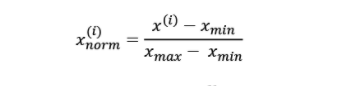

La technique de standardisation est utilisée pour centrer les colonnes de features à la moyenne 0 avec un écart type de 1 afin que les colonnes de features aient les mêmes paramètres qu'une distribution normale standard. Contrairement à la normalisation, la standardisation conserve des informations sur les valeurs aberrantes. StandardScaler est souvent utilisé lorsque on sait que la distribution des données est normale. 


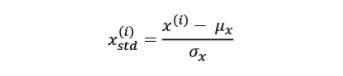

Source : https://vitalflux.com/minmaxscaler-standardscaler-python-examples/

Ici, nous avons beaucoup de colonnes et nous ne pouvons pas dire que toutes les colonnes ont une distribution normales, donc nous allons effectuer min-max scaling.

In [18]:
# Fit scaler pour le training data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)

In [8]:
# Pour Héroku
scaler2 = MinMaxScaler(feature_range = (0, 1))
scaler2.fit(data_train2)
scaled_train2 = scaler2.transform(data_train2)

In [19]:
# Créer un dataframe pour garder les noms de colonnes
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)

In [9]:
# Créer un dataframe pour garder les noms de colonnes (Pour Héroku)
data_train2 = pd.DataFrame(scaled_train2, index=data_train2.index, columns=data_train2.columns)

In [408]:
skid = data[['SK_ID_CURR']]

In [20]:
# Data sans target
X = data_train.drop('TARGET', axis=1)

In [21]:
# Data target
Y = data_train[['TARGET']]

In [10]:
# Data sans target pour Héroku
X2 = data_train2.drop('TARGET', axis=1)

In [11]:
# Récupérer ID pour Héroku
skid = data2[['SK_ID_CURR']]

In [12]:
# Récupérer ID crédit pour Héroku
X2 = pd.merge(skid, X2, left_index = True, right_index = True)

In [13]:
# Export pour l'API
X2.to_csv('X.csv')

Nous allons maintenant diviser les données en données d'entrainement et données de test.

Le paramètre de stratification conservera la proportion du target comme dans l'ensemble de données d'origine, ainsi que dans les ensembles de données d'apprentissage et de test.

In [22]:
# Diviser les données en train et test pour entrainer les modèles
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, stratify=Y.values, test_size=0.3, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215254, 542), (92253, 542), (215254, 1), (92253, 1))

### 1.2 Baseline <a class="anchor" id="basel"></a>
Nous allons maintenant créer un modèle baseline. 
« DummyClassifier » est un classificateur qui fait des prédictions sans essayer de trouver des modèles dans les données. La stratégie uniforme génère des prédictions uniformément au hasard à partir de la liste des classes uniques observées en y, c'est-à-dire que chaque classe a une probabilité égale.

Nous allons d'abord créer certaines fonctions qui calculent les scores du modèle et qui génère une matrice de confusion.

Pour la précision sur le métrique AUC qui est un des plus importants mesures de la performance des modèles :
Area under Curve (AUC) ou la Receiver operating characteristic (ROC) est utilisée pour évaluer et comparer les performances du modèle de classification binaire. Il mesure le pouvoir de discrimination du modèle de classification prédictive. En termes simples, il vérifie dans quelle mesure le modèle est capable de distinguer (séparer) les événements et les non-événements. 

Pour un modèle idéal, on a AUC=1, pour un modèle aléatoire, on a AUC=0.5. On considère habituellement que le modèle est bon dès lors que la valeur de l’AUC est supérieure à 0.7. Un modèle bien discriminant doit avoir une AUC entre 0.87 et 0.9. Un modèle ayant une AUC supérieure à 0.9 est excellent. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1,0 (100%).


Source : https://www.xlstat.com/fr/solutions/fonctionnalites/courbes-roc#:~:text=L'AUC%20correspond%20%C3%A0%20la,ci%2Ddessus%20en%20rouge)

https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308261-evaluez-un-algorithme-de-classification-qui-retourne-des-scores

In [46]:
# Obtenir les scores des données train
def models_score_train(model, X_train, y_train):
    output = {
        'AUC': roc_auc_score(y_train, model.predict_proba(X_train)[:,1]),
        'Accuracy': accuracy_score(y_train, model.predict(X_train)),
        'Precision': precision_score(y_train,model.predict(X_train)),
        'Recall': recall_score(y_train, model.predict(X_train)),
        'F1': f1_score(y_train, model.predict(X_train))
        }
    return output

In [26]:
# Obtenir les scores des données test
def models_score(model, X_test, y_test):
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [24]:
# Pour la matrice de confusion
def cf_matrix(model, y_true, y_pred):
    fig = plt.figure(figsize=(20,15))
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [37]:
# Baseline et ses score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 

dummy_clf = DummyClassifier(strategy="uniform")
# Entraînement
dummy_clf.fit(X_train, y_train)
models_score(dummy_clf, X_train, y_train)

{'AUC': 0.5,
 'Accuracy': 0.4996802272012834,
 'Precision': 0.08096769986523497,
 'Recall': 0.4973125503896802,
 'F1': 0.13891634803692995}

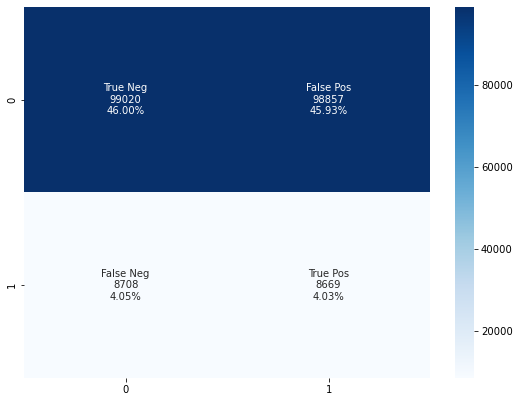

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix(dummy_clf, y_train, dummy_clf.predict(X_train))

### 1.3 Traitement des données déséquilibrées <a class="anchor" id="traitem"></a>

Le jeu de données est déséquilibré (92% de bon clients), donc nous devons appliquer un traitement de rééquilibrage. Nous allons utiliser SMOTE pour transformer les données d'entrainement dséséquilibrées en équilibrées.

Le SMOTE fonctionne en choisissant au hasard un point de la classe minoritaire et en calculant les k plus proches voisins pour ce point. Les points synthétiques sont ajoutés entre le point choisi et ses voisins.

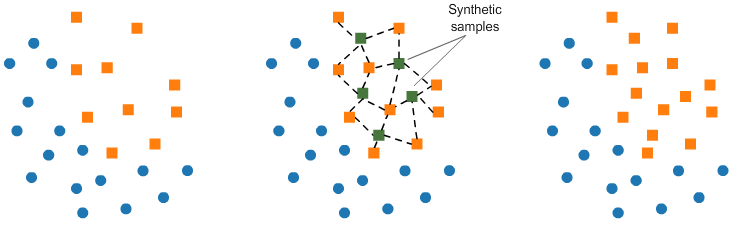

In [259]:
print("Label 1, avant d'utiliser SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, avant d'utiliser SMOTE: {} ".format(sum(y_train==0)))

Label 1, avant d'utiliser SMOTE: [17377] 
Label 0, avant d'utiliser SMOTE: [197877] 


In [260]:
# SMOTE
import time
import sklearn
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [261]:
print("Label 1, après l'utilisation SMOTE: {} ".format(sum(y_train_res==1)))
print("Label 0, après l'utilisation SMOTE: {} ".format(sum(y_train_res==0)))

Label 1, après l'utilisation SMOTE: 197877 
Label 0, après l'utilisation SMOTE: 197877 


Lors de la validation croisée (via un GridsearchCV), pour éviter le data leakage, l’oversampling doit être appliqué uniquement sur les plis utilisés pour le fit et non sur le pli utilisé pour le predict en utilisant "pipeline". Pour l’entrainement du modèle, les données équilibrées doivent être utilisées.

## 2. Les tests de différents algorithmes <a class="anchor" id="test"></a>
Nous allons maintenant tester deux différents algorithmes de machine learning appelés ensemblistes : Random Forest Classifier et Light GBM classifier.

### 2.1 Random forest classifier <a class="anchor" id="RF"></a>
Le Random Forest Classifier est un algorithme de classification qui combine la sortie de plusieurs arbres de décision pour atteindre un seul résultat.

Ici pour éviter le data leakage, nous allons appliquer l'oversampling uniquement sur les plis utilisés pour le fit et non sur le pli utilisé pour le predict en utilisant "pipeline". Pour l’entrainement du modèle, nous allons utiliser les données équilibrées.

In [20]:
# Validation croisée 1
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline, Pipeline

rfc=RandomForestClassifier(random_state=42)
def rfc_gc(x,y):
    model = make_pipeline(sm, rfc)
    param_grid = { 
        'randomforestclassifier__n_estimators': [200, 500],
        'randomforestclassifier__max_features': ['sqrt', 'log2'],
        'randomforestclassifier__max_depth' : [6,7],
        'randomforestclassifier__criterion' :['gini', 'entropy'] # "auto" est enlevé car il y a warning
    }
    
    CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv= 5, n_jobs = 6, verbose=10)
    CV_rfc.fit(x, y)
    return CV_rfc.best_params_

In [21]:
# Validation croisée 1
rfc_gc(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 500}

In [66]:
# Test de temps de calcul
import time
temps1 = time.time()

# Création de modèle RFC
rfc=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=7, criterion='gini')
rfc.fit(X_train_res, y_train_res)

duration1 = time.time() - temps1
print("Temps d'exécution du modèle RFC :  ", "%15.2f" % duration1, "secondes")

Temps d'exécution du modèle RFC :            297.91 secondes


In [109]:
# Score avec les données train
models_score_train(rfc, X_train_res, y_train_res)

{'AUC': 0.9274299397173476,
 'Accuracy': 0.851294530274775,
 'Precision': 0.8567081306320176,
 'Recall': 0.8437062530638648,
 'F1': 0.8501574837232869}

In [44]:
# Score avec les données test
print('Résultat de classification :')
models_score(rfc, X_test, y_test)

Résultat de classification :


{'AUC': 0.6571834413317164,
 'Accuracy': 0.8116267221662168,
 'Precision': 0.15523941707147815,
 'Recall': 0.30059123891427036,
 'F1': 0.20474098480688266}

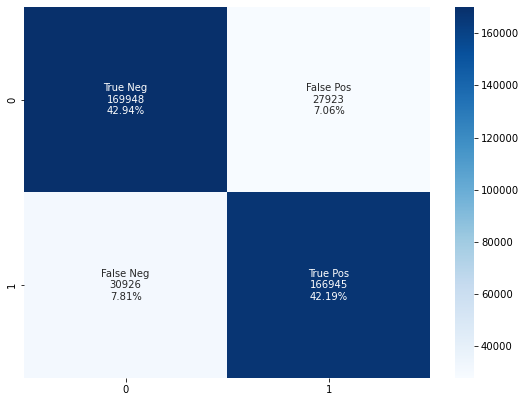

In [108]:
# Matrice de confusion train
cf_matrix(rfc, y_train_res, rfc.predict(X_train_res))

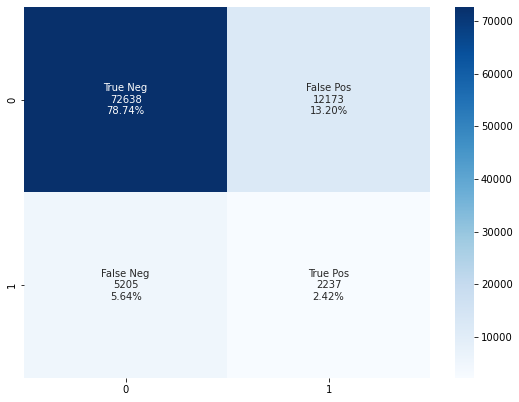

In [74]:
cf_matrix(rfc, y_test, rfc.predict(X_test))

Nous allons maintenant effectuer une autre validation croisée en augmentant les valeurs de n_estimators et max_depth.

In [22]:
# Un autre test
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline, Pipeline

rfc=RandomForestClassifier(random_state=42)
def rfc_gc2(x,y):
    model = make_pipeline(sm, rfc)
    param_grid = { 
        'randomforestclassifier__n_estimators': [500, 700],
        'randomforestclassifier__max_features': ['log2'], # log2 était meilleur avec la validation croisée 1
        'randomforestclassifier__max_depth' : [7,8,9], 
        'randomforestclassifier__criterion' :['gini'] # "gini" était meileur avec la validation croisée 1
    }
    
    CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv= 5, n_jobs = 6, verbose=10)
    CV_rfc.fit(x, y)
    return CV_rfc.best_params_

In [23]:
rfc_gc2(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__n_estimators': 700}

In [64]:
# Test de temps de calcul
import time
temps1 = time.time()

# Création de modèle RFC
rfc1=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 700, max_depth=9, criterion='gini')
rfc1.fit(X_train_res, y_train_res)

duration1 = time.time() - temps1
print("Temps d'exécution du modèle RFC :  ", "%15.2f" % duration1, "secondes")

Temps d'exécution du modèle RFC :            529.58 secondes


In [112]:
# Score avec les données train
models_score_train(rfc1, X_train_res, y_train_res)

{'AUC': 0.9457379627094585,
 'Accuracy': 0.8766923904968389,
 'Precision': 0.8834162375707943,
 'Recall': 0.8679240515285211,
 'F1': 0.8756016233633805}

In [46]:
# Score avec les données test
print('Résultat de classification :')
models_score(rfc1, X_test, y_test)

Résultat de classification :


{'AUC': 0.6661580926558768,
 'Accuracy': 0.8313008791042026,
 'Precision': 0.16472628189249441,
 'Recall': 0.2680730986294007,
 'F1': 0.20406075793995804}

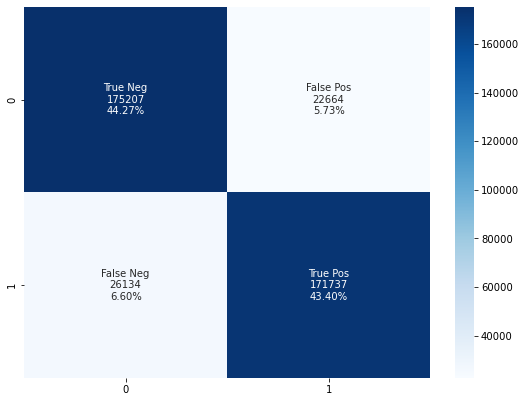

In [110]:
# Matrice de confusion train
cf_matrix(rfc1, y_train_res, rfc1.predict(X_train_res))

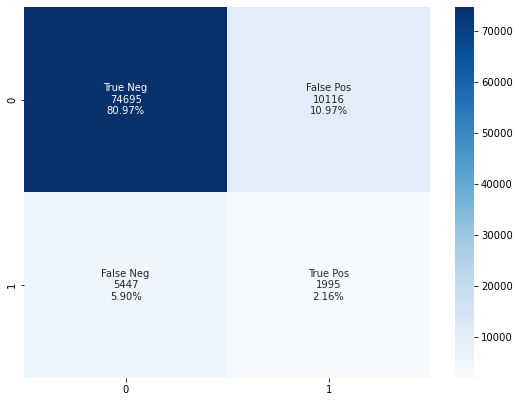

In [73]:
# Matricue de confusion données test
cf_matrix(rfc1, y_test, rfc1.predict(X_test))

Le temps de calcul a augmenté mais la performance du modèle a été amélioré. 

Nous essayons maintenant d'augmenter encore le n_estimatoes et max_depth.

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Test de la hausse de max_depth et n_estimators
# Création de modèle RFC
temps1 = time.time()
rfc2=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 1000, max_depth=10, criterion='gini')
rfc2.fit(X_train_res, y_train_res)

duration1 = time.time() - temps1
print("Temps d'exécution du modèle RFC :  ", "%15.2f" % duration1, "secondes")

Temps d'exécution du modèle RFC :            767.76 secondes


Temps de calcul a beaucoup augmenté.

In [47]:
# Score avec les données train
models_score_train(rfc2, X_train_res, y_train_res)

{'AUC': 0.9546171084510817,
 'Accuracy': 0.8900276434350632,
 'Precision': 0.8972426820668818,
 'Recall': 0.8809462443841376,
 'F1': 0.8890197878416973}

In [48]:
# Score avec les données train
models_score_train(rfc2, X_test, y_test)

{'AUC': 0.6726240178469707,
 'Accuracy': 0.8425525457166705,
 'Precision': 0.174979333149628,
 'Recall': 0.2557733619763695,
 'F1': 0.20779929097354785}

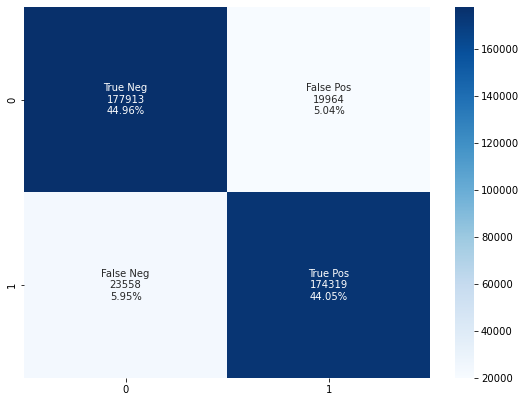

In [49]:
# Matrice de confusion train
cf_matrix(rfc2, y_train_res, rfc2.predict(X_train_res))

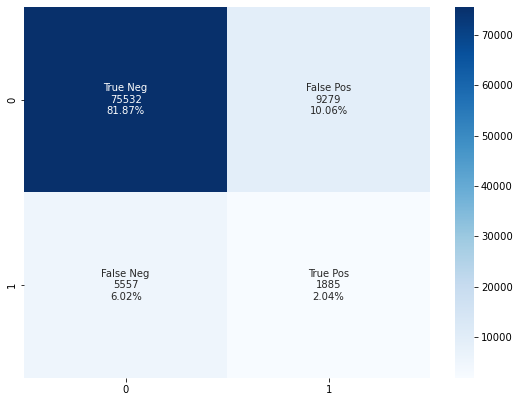

In [79]:
cf_matrix(rfc2, y_test, rfc2.predict(X_test))

AUC a amélioré pour les données de train et test. Pourtant nous observons la hausse de temps de calcul et la hausse de False négative avec les données de test. Comme le score n'a amélioré que légèrement, il faudrait garder le deuxième modèle.  

### 2.2 LightGBM classifier <a class="anchor" id="LGB"></a>

Le Light GBM classifier est un algorithme de classification ensembliste qui utilise un algorithme d'apprentissage basé sur un arbre. LightGBM fait pousser les arbres verticalement (au niveau des feuilles) par rapport à d'autres algorithmes d'apprentissage basés sur les arbres qui poussent horizontalement (au niveau des niveaux). Sa vitesse d’entraînement est rapide qui utilise moins de mémoire, et il est capable de traiter des données à grande échelle. 

Les 5 principaux hyper-paramètres à optimiser sont :

* num_leaves : nombre maximum de feuilles dans un arbre, paramètre principal à régler pour un modèle d'arbre ;
* min_child_samples : nombre minimum de données dans une feuille ;
* max_depth : profondeur maximale de l'arbre ;
* learning_rate : taux de rétrécissement, détermine la vitesse à laquelle le modèle peut apprendre ;
* reg_alpha : régularisation, gestion de l'overfitting.


Num_leaves, min_child_samples, max_depth et reg_alpha peuvent affecter à la fois accuracy et overfitting. Plus la valeur de num_leaves et max_depth est élevée, plus l'accuracy est élevée et cela provoque également plus de l'overfitting. Plus le min_child_samples et le reg_alpha sont élevés, moins de l'overfitting mais réduirait l'accuracy. Le taux d'apprentissage détermine la vitesse d'apprentissage du modèle, mais affecterait également l'accuracy.

Source : https://towardsdatascience.com/hyper-parameter-tuning-in-python-1923797f124f

In [89]:
# Validation croisée : utilisation de pipeline
import lightgbm as lgb
lgb=lgb.LGBMClassifier()

def lgbc_gcv(x, y):
    model = make_pipeline(sm, lgb)
    # Définir les paramétres
    parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
                  'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
    
    # Définir le scoring
    clf=GridSearchCV(lgb, parameters, scoring='roc_auc', cv= 5, n_jobs = 6, verbose=10)
    clf.fit(x, y)
    return clf.best_params_

In [90]:
lgbc_gcv(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


{'learning_rate': 0.1,
 'max_depth': 20,
 'min_child_samples': 10,
 'num_leaves': 100,
 'reg_alpha': 0.01}

In [94]:
# Création du modèle light GBM et predire 
import lightgbm as lgb
start = time.time()

lgb1 = lgb.LGBMClassifier(num_leaves=100, min_child_samples=10, max_depth= 20, learning_rate=0.1, reg_alpha=0.01)
lgb1.fit(X_train_res, y_train_res)

# Score avec les données train
print('Résultat de classification :')
print(models_score_train(lgb1, X_train_res, y_train_res))

end = time.time()
print("Temps d'exécution en secondes :")
print(end - start)

Résultat de classification :
{'AUC': 0.9887882248559763, 'Accuracy': 0.9581444476451829, 'Precision': 0.9980660509529644, 'Recall': 0.9180678320724108, 'F1': 0.956396986432629}
Temps d'exécution en secondes :
22.5361647605896


In [95]:
# Score avec les données test
models_score(lgb1, X_test, y_test)

{'AUC': 0.763134446144476,
 'Accuracy': 0.9189836644878757,
 'Precision': 0.4735099337748344,
 'Recall': 0.03843052942757323,
 'F1': 0.07109122545364156}

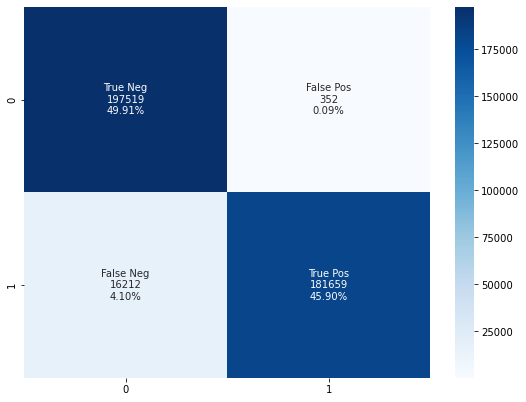

In [96]:
# Matrice de confusion train
cf_matrix(lgb1, y_train_res, lgb1.predict(X_train_res))

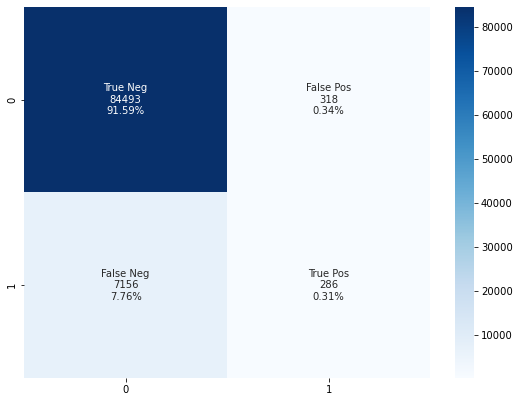

In [97]:
# Matrice de confusion
cf_matrix(lgb1, y_test, lgb1.predict(X_test))

### Fine tuning test

Nous avons eu le résultat de la validation croisée avec la maximum des valeurs de max_depth (20) et num_leaves (100). Nous essayons d'augmenter ces valeurs pour voir si nous pouvons encore améliorer la performance du modèle tout en contrôlant l'overfittng via les scores de données test.

In [98]:
# Test 1
# Création de modèle light GBM et predire 
start = time.time()

lgb2 = lgb.LGBMClassifier(num_leaves=120, min_child_samples=10, max_depth= 30, learning_rate=0.1, reg_alpha=0.01)
lgb2.fit(X_train_res, y_train_res)
# Score avec les données train
print('Résultat de classification :')
print(models_score_train(lgb2, X_train_res, y_train_res))

end = time.time()
print("Temps d'exécution en secondes :")
print(end - start)

Résultat de classification :
{'AUC': 0.990569192520375, 'Accuracy': 0.9587711185570397, 'Precision': 0.9983694667552389, 'Recall': 0.9190432150239297, 'F1': 0.9570654176095995}
Temps d'exécution en secondes :
24.16875958442688


In [99]:
# Score avec les données test
models_score(lgb2, X_test, y_test)

{'AUC': 0.76235810367616,
 'Accuracy': 0.9191462608262062,
 'Precision': 0.48635634028892455,
 'Recall': 0.04071486159634507,
 'F1': 0.07513949163050218}

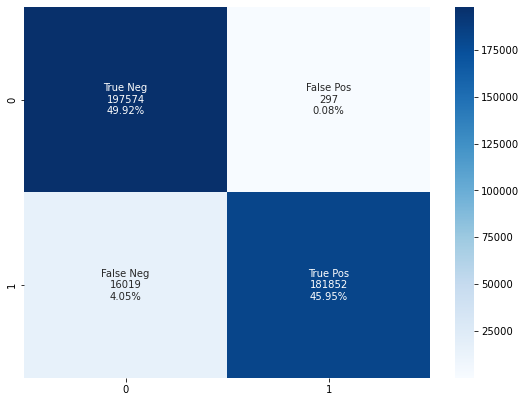

In [100]:
# Matrice de confusion train
cf_matrix(lgb2, y_train_res, lgb2.predict(X_train_res))

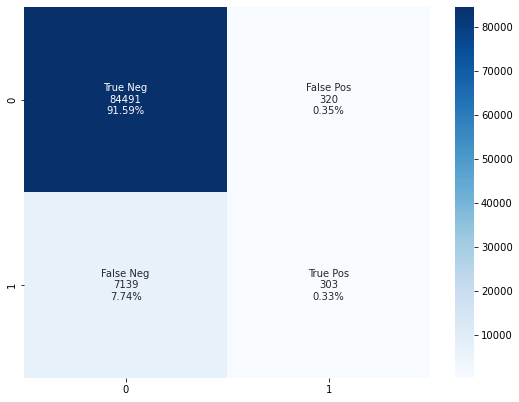

In [101]:
# Matrice de confusion test
cf_matrix(lgb2, y_test, lgb2.predict(X_test))

In [262]:
# Test 2
# Création de modèle light GBM et predire 
start = time.time()

lgb3 = lgb.LGBMClassifier(num_leaves=140, min_child_samples=10, max_depth= 40, learning_rate=0.1, reg_alpha=0.01)
lgb3.fit(X_train_res, y_train_res)

# Score avec les données train
print('Résultat de classification :')
print(models_score_train(lgb3, X_train_res, y_train_res))

end = time.time()
print("Temps d'exécution en secondes :")
print(end - start)

Résultat de classification :
{'AUC': 0.9920248785440193, 'Accuracy': 0.9594722984480258, 'Precision': 0.9985195582800557, 'Recall': 0.9203090808936865, 'F1': 0.9578204099880343}
Temps d'exécution en secondes :
26.030216693878174


In [263]:
# Score avec les données test
models_score(lgb3, X_test, y_test)

{'AUC': 0.7670440419611783,
 'Accuracy': 0.9188210681495452,
 'Precision': 0.4687975646879756,
 'Recall': 0.041353383458646614,
 'F1': 0.07600246761258483}

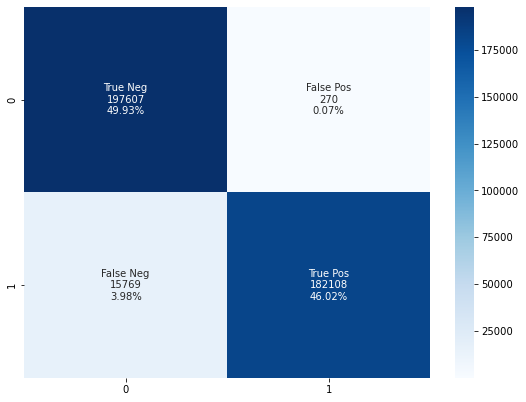

In [264]:
# Matrice de confusion train
cf_matrix(lgb3, y_train_res, lgb3.predict(X_train_res))

In [130]:
lgb3.predict(X_train_res)

array([0., 0., 0., ..., 1., 1., 1.])

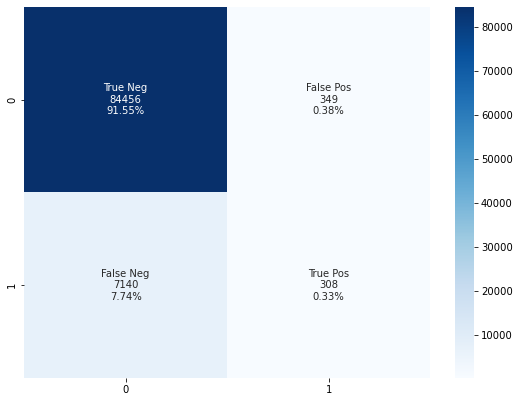

In [265]:
# Matrice de confusion
cf_matrix(lgb3, y_test, lgb3.predict(X_test))

3ème modèle a eu la meilleur performance notamment pour l'AUC avec le temps de calcul de 26 secondes.  

### 2.3 Choix du modèle <a class="anchor" id="choix"></a>
Nous allons maintenant comparer la performance des modèles que nous avons vu.

Performance des modèles avec les données train :
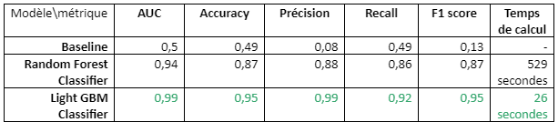

**Le modèle Light GBM a été choisi** : le modèle Light GBM Classifier est plus performant en termes de métriques mesurés et le temps de calcul. Avec les données de test, AUC est de 0,76 et le résultat de la matrice de confusion est cohérent par rapport à la réalité (True negative 91,5%, True positive 0,4%, False negative 7,7% et False positive 0,4%).

## 3. Les tests fonction coût (avec le modèle choisi) <a class="anchor" id="coût"></a>
Les erreurs de prédiction sont un coût pour l’entreprise, donc il est nécessaire d’optimiser ces erreurs. 
Il existe deux types qui consiste un coût pour l’entreprise : 
* False positive (FP) : les cas où la prédiction est positive, mais où la valeur réelle est négative. C’est le manque à gagner, nous perdons les clients aptes pour les crédits ;
* False negative (FN) : les cas où la prédiction est négative, mais où la valeur réelle est positive. Cela signifie que nous accordons aux clients qu’il ne faut pas, donc cela peut être traduit par le coût significatif par le défaut de paiement.

L'idée ici est d'éviter les clients avec un fort risque de défaut, donc **minimiser le FN**.

Le recall calcule le pourcentage de prédictions correctes pour la classe positive sur toutes les prédictions positives qui pourraient être faites. **La maximisation du recall minimisera les erreurs de FN**.
Pour le calcul de precision et recall :

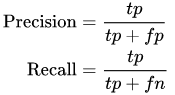


Notre but est de minimiser le FN, donc nous cherchons à pénaliser plus de FN dans la prédiction. Nous utilisons ici le F bêta score pour la recherche d’une fonction coût. Cette mesure permet d’accorder l’importance au recall en fixant une valeur bêta plus grande que 2, ce qui donne moins de poids au precision et plus de poids au recall dans le calcul du score.

Le F1-score appartient à la famille plus large des F-beta scores. Dans le cas du F1-score, les erreurs (FN+FP) faites par le modèle sont pondérées par un facteur 1⁄2. Le F1-score accorde ainsi la même importance à la precision et au recall, et donc aux faux positifs et aux faux négatifs.

Le F-beta score permet de varier la pondération de ces termes :
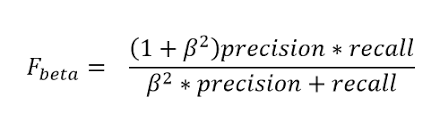


Source : https://machinelearningmastery.com/fbeta-measure-for-machine-learning/

Nous allons voir comment varie un F beta score selon les valeurs de beta pour pouvoir maximiser ce score à un seuil donné pour minimiser les coûts par la suite.

In [210]:
# Test de tous les seuils selon les différentes valeurs de bêta pour voir l'évolution de f bêta score
# https://medium.com/@douglaspsteen/beyond-the-f-1-score-a-look-at-the-f-beta-score-3743ac2ef6e3
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score

# Predict la probabilté 
y_train_probs = lgb3.predict_proba(X_train_res)[:,1]

# f-beta, precision, recall scores aux différentes thresholds
f1_scores = []
f0_5_scores = []
f2_scores = []
f3_scores = []
f4_scores = []
f5_scores = []
precision_scores = []
recall_scores = []

# Definir thresholds, entre 0 et 1
probability_thresholds = np.linspace(0, 1, num=100)

# Trouver les scores à chaque threshold
for p in probability_thresholds:
    
    y_train_preds = []
    
    for prob in y_train_probs:
        if prob > p:
            y_train_preds.append(1)
        else:
            y_train_preds.append(0)
            
    f1 = f1_score(y_train_res, y_train_preds)
    f0_5 = fbeta_score(y_train_res, y_train_preds, beta=0.5)
    f2 = fbeta_score(y_train_res, y_train_preds, beta=2)
    f3 = fbeta_score(y_train_res, y_train_preds, beta=3)
    f4 = fbeta_score(y_train_res, y_train_preds, beta=4)
    f5 = fbeta_score(y_train_res, y_train_preds, beta=5)
    prec = precision_score(y_train_res, y_train_preds)
    rec = recall_score(y_train_res, y_train_preds)
         
    print([f1, f0_5, f2, f3, f4, f5, prec, rec])    
    f1_scores.append(f1)
    f0_5_scores.append(f0_5)
    f2_scores.append(f2)
    f3_scores.append(f3)
    f4_scores.append(f4)
    f5_scores.append(f5)
    precision_scores.append(prec)
    recall_scores.append(rec)

[0.6666666666666666, 0.5555555555555556, 0.8333333333333334, 0.9090909090909091, 0.9444444444444444, 0.9629629629629629, 0.5, 1.0]
[0.6709914358041373, 0.5603731724129727, 0.836023336268394, 0.91068503540906, 0.9454521078202934, 0.9636444180542586, 0.5048837743359444, 0.9999898924046474]
[0.7023894056664063, 0.5960081148808767, 0.8549976532781068, 0.9217542100594143, 0.9523727942436183, 0.9682780695994747, 0.5413477667198433, 0.9998180632836545]
[0.7411401348611096, 0.6416791769621043, 0.877090025807333, 0.9342119312807515, 0.9599548898505305, 0.9732164187722078, 0.5889847042878632, 0.999292468325323]
[0.7766444879065151, 0.6853112357921334, 0.8960655249927881, 0.9444746960983653, 0.9659627647182331, 0.976954148137314, 0.6354889762411781, 0.9984131075296532]
[0.807217578785015, 0.7244232965080203, 0.9113790156816554, 0.9523416496527225, 0.9702990546227908, 0.9794316890063435, 0.6780587715771278, 0.9971597657059398]
[0.8333840818743128, 0.7590594322172892, 0.9238438941879904, 0.95852497

C:\Users\10159596\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


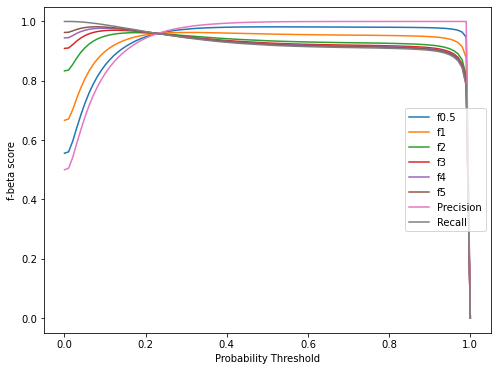

In [211]:
# Plot courbe de f_beta, precision, recall

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probability_thresholds, f0_5_scores, label='f0.5')
ax.plot(probability_thresholds, f1_scores, label='f1')
ax.plot(probability_thresholds, f2_scores, label='f2')
ax.plot(probability_thresholds, f3_scores , label='f3')
ax.plot(probability_thresholds, f4_scores, label='f4')
ax.plot(probability_thresholds, f5_scores, label='f5')
ax.plot(probability_thresholds, precision_scores, label='Precision')
ax.plot(probability_thresholds, recall_scores, label='Recall')
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('f-beta score')
ax.legend(loc='center right')
plt.show()
# 0,1

Nous trouvons la valeur maximum de f-bêta score lorsque le bêta est plus grand que 3 pour un seuil autours de 0,1. Le but est de minimiser le FN tout en restant le nombre de FP raisonnable, si nous prenons le bêta le plus petit possible : un peu plus grand que 3. Le coefficient de bêta dans le calcul de F bêta score est en carré, carré de ce bêta nous donne environ 10. Cela nous la fonction coût :  

**Coût = 10*FN + FP**   

D'où FN est le nombre de false négative, et FP est le nombre de false positif. 


Maintenant nous allons tester les différents seuils autours de 0,1 pour déterminer le seuil qui minimise la fonction coût. 

In [266]:
# Test avec les différentes valeurs de seuil

candidate = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]
for proba in candidate:
    y_pred = np.where(lgb3.predict_proba(X_train_res) > proba, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_train_res, y_pred[:,1]).ravel()
    print("Pour un seuil ", proba, "coût estimé est ", (10*fn + fp))

Pour un seuil  0.07 coût estimé est  77779
Pour un seuil  0.08 coût estimé est  71474
Pour un seuil  0.09 coût estimé est  67339
Pour un seuil  0.1 coût estimé est  64607
Pour un seuil  0.11 coût estimé est  62946
Pour un seuil  0.12 coût estimé est  62613
Pour un seuil  0.13 coût estimé est  62840


Nous allons avoir le coût minimum avec un seuil = 0.12

In [267]:
# La prédiction avec le meilleur modèle
y_pred = np.where(lgb3.predict_proba(X_train_res) > 0.12, 1, 0)

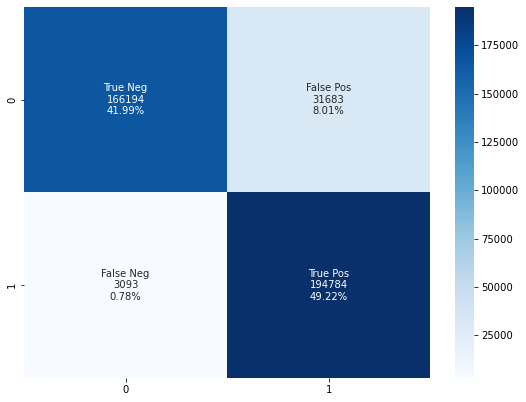

In [268]:
# Matrice de confusion train
cf_matrix(lgb3, y_train_res, y_pred[:,1])

Le pourcentage de FN a beaucoup baissé.

Nous allons maintenant optimiser les hyperparamètres pour améliorer la performance du modèle tout en minimisant le coût : validation croisée manuelle en fixant le seuil 0,12.

In [245]:
# Redéterminer les hyperparamètres
import itertools
# Définir les paramétres
parameters = {'num_leaves':[100, 120], 'min_child_samples':[5,10,15],'max_depth':[20,30],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}

hp_all_comb = [dict(zip(parameters.keys(), elem)) for elem in list(itertools.product(*parameters.values()))]
np.random.shuffle(hp_all_comb)

for hp in hp_all_comb: 
    lgb_sm4 = lgb.LGBMClassifier(num_leaves=hp['num_leaves'], min_child_samples=hp['min_child_samples'], 
                                 max_depth=hp['max_depth'], learning_rate=hp['learning_rate'], reg_alpha=hp['reg_alpha'])

    lgb_sm4.fit(X_train_res, y_train_res)
    predicted= np.where(lgb_sm4.predict_proba(X_train_res) > 0.12, 1, 0)

    # Score avec les données train
    print("Résultat de classification :",
    hp,
    "AUC:", roc_auc_score(y_train_res, lgb_sm4.predict_proba(X_train_res)[:,1]),
    "Accuracy:", accuracy_score(y_train_res, predicted[:,1]),
    "Precision:", precision_score(y_train_res,predicted[:,1]),
    "Recall:", recall_score(y_train_res, predicted[:,1]),
    "Fbeta:", fbeta_score(y_train_res, predicted[:,1], beta=4))

Résultat de classification : {'num_leaves': 120, 'min_child_samples': 10, 'max_depth': 30, 'learning_rate': 0.05, 'reg_alpha': 0.03} AUC: 0.9824227283480846 Accuracy: 0.8558530557787649 Precision: 0.7874680536616832 Recall: 0.9747967109884723 Fbeta: 0.9613442638522985
Résultat de classification : {'num_leaves': 100, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.05, 'reg_alpha': 0.01} AUC: 0.9813459229555852 Accuracy: 0.8499931773731371 Precision: 0.7803933000522295 Recall: 0.9741043407068242 Fbeta: 0.9600858267238962
Résultat de classification : {'num_leaves': 100, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.2, 'reg_alpha': 0.03} AUC: 0.9949987190794759 Accuracy: 0.9275866599956537 Precision: 0.8807695769576958 Recall: 0.9890635818285651 Fbeta: 0.9819614678985732
Résultat de classification : {'num_leaves': 120, 'min_child_samples': 5, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.03} AUC: 0.991058913435429 Accuracy: 0.9085237351607865 Precision: 

Meilleur Résultat (en AUC) de classification :{'num_leaves': 120, 'min_child_samples': 5, 'max_depth': 30, 'learning_rate': 0.2, 'reg_alpha': 0} 

* AUC: 0.99676 
* Accuracy: 0.9355 
* Precision: 0.8907 
* Recall: 0.9928 
* Fbeta: 0.9861

In [269]:
# Avec les meilleurs paramètres : création du modèle 
start = time.time()
lgb_final = lgb.LGBMClassifier(num_leaves=120, min_child_samples=5, max_depth= 30, learning_rate=0.2, reg_alpha=0)
lgb_final.fit(X_train_res, y_train_res)
y_pred = np.where(lgb_final.predict_proba(X_train_res) > 0.12, 1, 0)

end = time.time()
print("Temps d'exécution en secondes :")
print(end - start)

Temps d'exécution en secondes :
17.422762632369995


In [395]:
# Pour le dashboard
import pickle
pickle.dump(lgb_final, open('model_final', 'wb'))

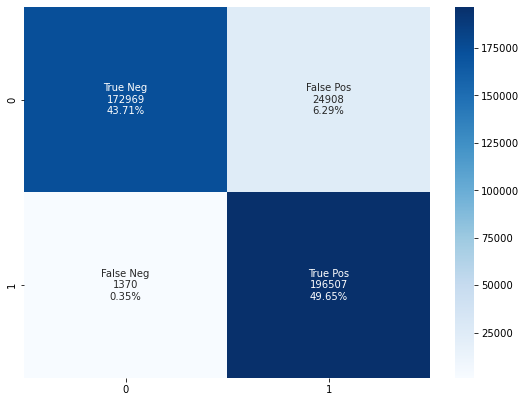

In [270]:
# Matrice de confusion train
cf_matrix(lgb_final, y_train_res, y_pred[:,1])

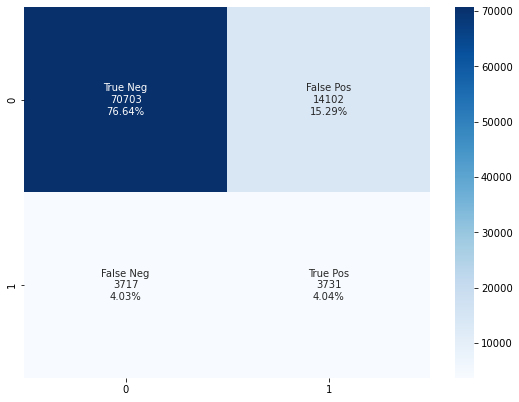

In [271]:
# Matrice de confusion test
y_pred_test = np.where(lgb_final.predict_proba(X_test) > 0.12, 1, 0)
cf_matrix(lgb_final, y_test, y_pred_test[:,1])

In [272]:
print("Résultat de classification avec les données test:",
    "AUC:", roc_auc_score(y_test, lgb_final.predict_proba(X_test)[:,1]),
    "Accuracy:", accuracy_score(y_test, y_pred_test[:,1]),
    "Precision:", precision_score(y_test, y_pred_test[:,1]),
    "Recall:", recall_score(y_test, y_pred_test[:,1]),
    "Fbeta:", fbeta_score(y_test, y_pred_test[:,1], beta=4))

Résultat de classification avec les données test: AUC: 0.7560864689202013 Accuracy: 0.8068463898193012 Precision: 0.20921886390399821 Recall: 0.5009398496240601 Fbeta: 0.4629674235954482


Avec l'optimisation des hyperparamètres après avoir trouvé le seuil qui minimise le coût, nous avons pu encore améliorer le pourcentage de FN par rapport au cas de l'usage du modèle sans ré-optimisation des hyperparamètre, tout en gardant le niveau de la performance raisonable du modèle avec les données de test.   

## 4. Interprétabilité globale et locale du modèle <a class="anchor" id="FI"></a>

Aujourd’hui, les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Il est donc important pour l’entreprise que les chargés de relation client puissent bien expliquer les décisions d’octroi de crédit. 

L’objectif métier est de comprendre et interpréter pourquoi un client donné est considéré comme bon ou mauvais, puis quelles sont ses features qui expliquent son résultat.  
Il existe plusieurs manières de l’interprétation :
1. Feature importance globale à l’élaboration du modèle : connaître d’une manière générale les principales features qui contribuent à l’élaboration du modèle ;
2. Feature importance locale : quelles features influencent les plus dans le calcul de score de chaque client ;
3. Feature importance issue de la moyenne des features importance locales.  

Pour le 1er cas :

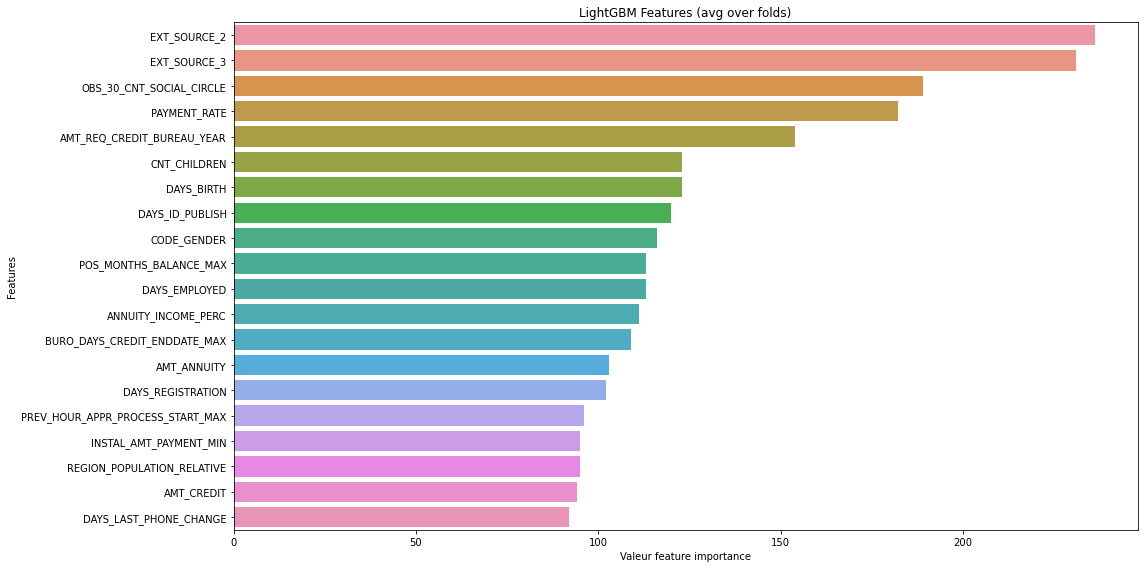

In [310]:
feature_imp = pd.DataFrame(sorted(zip(lgb_final.feature_importances_,X.columns)), columns=['Valeur feature importance','Features'])

plt.figure(figsize=(16, 8))
sns.barplot(x="Valeur feature importance", y="Features", data=feature_imp.sort_values(by="Valeur feature importance", ascending=False).head(20))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# https://www.kaggle.com/code/ashishpatel26/feature-importance-of-lightgbm/notebook

In [304]:
# Vérification
feat_importances.sort_values(ascending = False)

EXT_SOURCE_2                         236
EXT_SOURCE_3                         231
OBS_30_CNT_SOCIAL_CIRCLE             189
PAYMENT_RATE                         182
AMT_REQ_CREDIT_BUREAU_YEAR           154
                                    ... 
NAME_INCOME_TYPE_Unemployed            0
PREV_NAME_PRODUCT_TYPE_nan_MEAN        0
HOUSETYPE_MODE_terraced house          0
PREV_CHANNEL_TYPE_Car dealer_MEAN      0
NAME_INCOME_TYPE_Businessman           0
Length: 542, dtype: int32

Pour le modèle choisi Light GBM classifier, la feature importance est obtenu via un attribut feature_importances_.
Le graphique précédent montre que ce sont les features « EXT_SOURCE_2 », « EXT_SOURCE_3 » et « OBS_30_CNT_SOCIAL_CIRCLE » qui ont contribué les plus pour la création du modèle.

* EXT_SOURCE_2 : Score normalisé à partir d’une source de données externe numéro 2
* EXT_SOURCE_3 : Score normalisé à partir d’une source de données externe numéro 3
* OBS_30_CNT_SOCIAL_CIRCLE : Combien d'observations de l'environnement social du client avec un défaut de 30 DPD (jours de retard)


Pour le deuxième et le troisième cas, nous allons utiliser le librairie SHAP pour calculer les feature importance globale indépendante de l’algorithme.
Les chap valeurs nous permettent de décomposer toute prédiction en la somme des effets de chaque valeur de feature.

Nous allons créer l'objet explainer et obtenir les shap values.


*TreeExplainer - Cet explainer est utilisé pour les modèles basés sur : tree-like decision tree, random forest, et gradient boosting.

In [53]:
import shap
shap.initjs()

In [366]:
# Calcul de shap values
explainer = shap.TreeExplainer(lgb_final)
shap_values = explainer.shap_values(X_train_res)
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [70]:
# Pour le dashboard
shap_v = pd.DataFrame(shap_values[0])
shap_v.to_csv('shap_values.csv')

### Feature importance issue de la moyenne des features importance locales : summary plot 

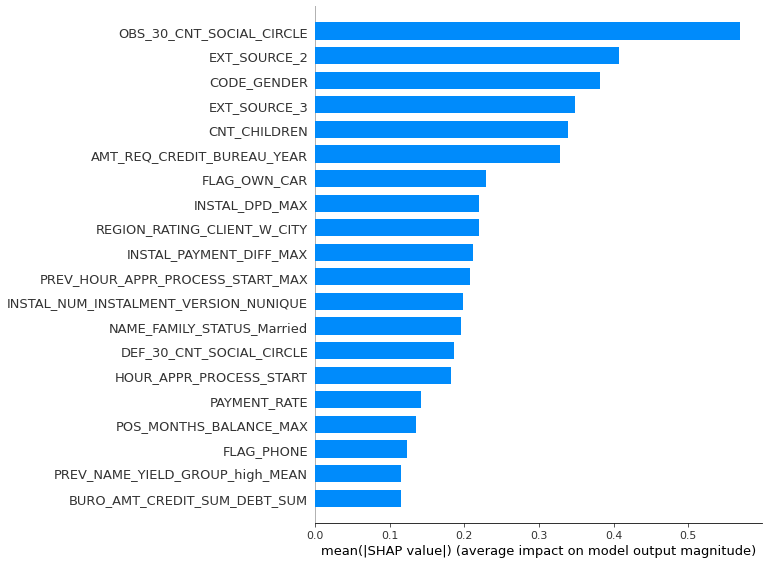

In [61]:
shap.summary_plot(shap_values[0], X, plot_type = "bar", max_display=20, color_bar=False)

Ce graphique dit qu'en moyenne de tous les clients, « OBS_30_CNT_SOCIAL_CIRCLE », « EXT_SOURCE_2 » et « CODE_GENDER » sont les features qui expliquent les plus dans le calcul de score. 

### Feature importance local : un exemple
En fin nous allons voir une exemple d'un client pour le deuxième cas.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


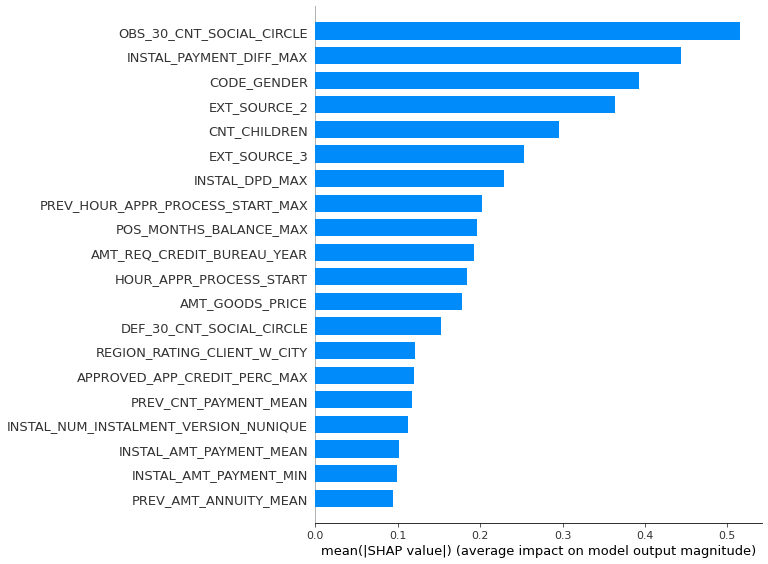

In [100]:
client = X.loc[[3]]
shapv = explainer.shap_values(client)
shap.summary_plot(shapv[0], client, plot_type = "bar", max_display=20, color_bar=False)

Pour ce client, la décision a été prise notamment en référant les features « OBS_30_CNT_SOCIAL_CIRCLE », « INSTAL_PAYMENT_DIFF_MAX » et « CODE_GENDER ».

* INSTAL_PAYMENT_DIFF_MAX : différence maximum entre la valeur du versement et le montant payé.